In [1]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import torch
import numpy as np 

In [164]:
image = cv2.imread('/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/Frames/Frame_392.png')
print(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


[[[99 91 81]
  [99 91 81]
  [98 90 80]
  ...
  [67 75 74]
  [67 75 74]
  [67 75 74]]

 [[99 91 81]
  [99 91 81]
  [98 90 80]
  ...
  [67 75 74]
  [67 75 74]
  [67 75 74]]

 [[99 91 81]
  [99 91 81]
  [98 90 80]
  ...
  [67 75 74]
  [67 75 74]
  [67 75 74]]

 ...

 [[77 79 81]
  [77 79 81]
  [76 78 80]
  ...
  [52 51 53]
  [52 51 53]
  [51 50 52]]

 [[76 78 80]
  [76 78 80]
  [75 77 79]
  ...
  [52 51 53]
  [52 51 53]
  [51 50 52]]

 [[76 78 80]
  [76 78 80]
  [75 77 79]
  ...
  [52 51 53]
  [52 51 53]
  [51 50 52]]]


In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [167]:
from segment_anything import build_sam, SamPredictor 
# input_box = np.array([1123.0, 589.0, 1194.0, 678.0])
input_point = np.array([[576.5, 598]])
input_label = np.array([1])

In [168]:
predictor = SamPredictor(build_sam(checkpoint="/Users/hirvapatel/Downloads/sam_vit_h_4b8939.pth"))
predictor.set_image(image)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

0.0007846257716049383


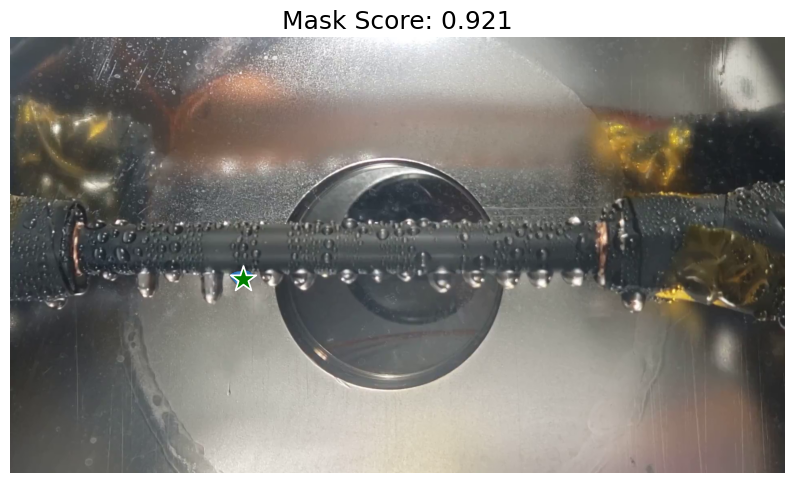

In [169]:
mask = masks[0]
score = scores[0]
positive_pixel_count = mask.sum() # assumes binary mask (True == 1)
h, w = mask.shape[-2:] # assumes NHWC data format, adapt as needed
area = positive_pixel_count / (w*h)
print(area)

# pixels = cv2.countNonZero(mask)
# print(pixels)
# for i, (mask, score) in enumerate(zip(masks, scores)):
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Mask Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show() 

In [61]:
print(mask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [119]:
import cv2
import numpy as np

def find_first_true_in_each_row(mask, bbox):
    x, y, w, h = bbox
    first_true_points = []
    # Iterate through each row in the mask
    for row in range(y+10, y+h):
        found = False
        for col in range(x,x+w):
            if mask[row, col]:  # Check if the mask is True
                first_true_points.append((row, col))  # Store the (row, column) coordinates
                found = True
                break
        if not found:
            first_true_points.append((row, None))  # If no true value is found, append None

    return first_true_points

def find_first_true_in_each_row_right(mask, bbox):
    x, y, w, h = bbox
    first_true_points = []
    # Iterate through each row in the mask
    for row in range(y+10, y+h):
        found = False
        col = x
        while col!=x+w:
            if mask[row, col]:  # Check if the mask is True
                first_true_points.append((row, col))  # Store the (row, column) coordinates
                found = True
                break
            col = col-1
        if not found:
            first_true_points.append((row, None))  # If no true value is found, append None

    return first_true_points

def calculate_contact_angle(mask, bounding_box):
    x, y, w, h = bounding_box
    
    # Find the first true mask points for each row
    first_true_points = find_first_true_in_each_row(mask, bounding_box)
    first_true_points_right = find_first_true_in_each_row_right(mask, (x+w, y, -w, h))
    # print(first_true_points)
    # print(first_true_points_right)

    # Store deltas and calculate angles for the first 5 rows
    angles = 0  
    angles_cnt = 0
    angles_right = 0
    angles_right_cnt = 0
    for row in range(min(35, len(first_true_points))):  # Only take first 5 rows
        col = first_true_points[row][1]
        if col is not None:  # If a true value was found
            delta_y = first_true_points[row][1] - x  # Calculate delta_y
            delta_x = first_true_points[row][0] - y  # No horizontal movement for the left edge

            # Calculate angle using arctan2
            angle_rad = np.arctan2(delta_y, delta_x)  # Use arctan2 for full range
            angle_deg = np.degrees(angle_rad)  # Convert to degrees

            # Store the angles
            if angle_deg!=0:
                angles = angles + angle_deg
                angles_cnt = angles_cnt + 1
        
        col = first_true_points_right[row][1]
        if col is not None:  # If a true value was found
            delta_y = x+w - first_true_points[row][1]   # Calculate delta_y
            delta_x = y - first_true_points[row][0]  # No horizontal movement for the left edge

            # Calculate angle using arctan2
            angle_rad = np.arctan2(delta_y, delta_x)  # Use arctan2 for full range
            angle_deg = np.degrees(angle_rad)  # Convert to degrees
            # print(angle_deg)
            # Store the angles
            if angle_deg!=0:
                angles_right = angles_right + angle_deg
                angles_right_cnt = angles_right_cnt + 1
    
    return (90 - angles/angles_cnt, 180 - angles_right/angles_right_cnt)



def draw_bounding_box_on_image(image, mask, output_path):
    # Ensure mask is binary (0 and 255)
    binary_mask = mask.astype(np.uint8) * 255

    # Find contours in the mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours were found
    if contours:
        # Assume the largest contour is the relevant area
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding box for the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)
        print(x, y, w, h)
        max_width = 0
        max_width_row = -1
        for row in range(mask.shape[0]):
            # Count the number of True values in this row (width)
            width = np.sum(mask[row])  # Count True values in the row
            if width > max_width:
                max_width = width
                max_width_row = row

        # Adjust the y-coordinate of the bounding box to the row with the largest width
        if max_width_row != -1:
            y_new = max_width_row
            h = h - (y_new - y) + 1
        # Draw the bounding box on the original image
        cv2.rectangle(image, (x, y_new-1), (x+ w, y_new + h), (0, 255, 0), 2)  # Green bounding box

        # Optionally, draw the contours (in blue)
        cv2.drawContours(image, [largest_contour], -1, (255, 0, 0), 1)

        # Save the output image
        cv2.imwrite(output_path, image)
        angles, angles_right = calculate_contact_angle(mask, (x, y_new, w, h))
        print(angles, angles_right)
    else:
        print("No contours found in the mask.")

# Example usage
# Assume `image` is your original image and `mask` is the binary mask variable
image_path = '/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/Frames/Frame_37.png'  # Path to your original image
output_path = './output_with_bounding_box.png'  # Path to save the output image

# Load the original image
image = cv2.imread(image_path)

# Assume `mask` is a binary numpy array with the same height and width as the image
# Call the function with the loaded image and the existing mask variable
draw_bounding_box_on_image(image, mask, output_path)


1055 578 50 80
82.57194579345258 59.754662581696536


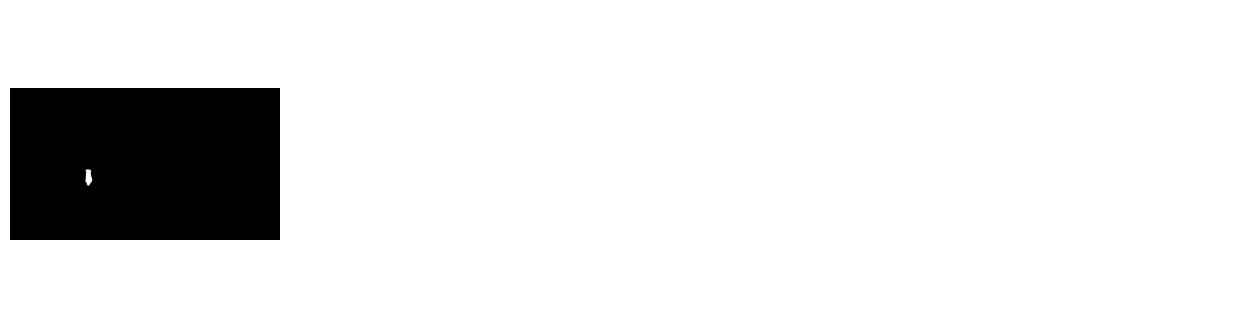

0

In [11]:
import supervision as sv

mask_bw = sv.plot_images_grid(
    images = masks,
    grid_size= (1,4),
    size = (16,4)
)

cv2.countNonZero(mask_bw)


In [120]:
def read_filtered_frames(filename):
    lines = []
    with open(filename, 'r') as file:
        for line in file:
            # Each line contains coordinates in the format: x1,y1,x2,y2
            coordinates = list(map(float, line.strip().split(',')))
            lines.append(coordinates)
    return lines

def calculate_midpoint(bbox):
    l, x1, y1, x2, y2 = bbox
    return [(x1 + x2) / 2, (y1 + y2) / 2]

def process_line(line,predictor,areas,frame_num):
    # Read frame
    # print(line)
    frame_path = f"/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/Filtered_Frames/Frame_{int(line[0])}.png"
    image = cv2.imread(frame_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculate midpoint of bounding box
    bbox_midpoint = calculate_midpoint(line)
    input_point = np.array([bbox_midpoint])
    input_label = np.array([1])

    
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )
    mask = masks[0]
    score = scores[0]
    positive_pixel_count = mask.sum() # assumes binary mask (True == 1)
    h, w = mask.shape[-2:] # assumes NHWC data format, adapt as needed
    area = positive_pixel_count / (w*h)
    print(area)
    areas.append(area)
    frame_num.append(int(line[0]))
    # print(f"Processing frame {line} with midpoint {bbox_midpoint}")

filtered_frames_file = "/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/BG_Subtraction/filtered_frames.txt"
lines = read_filtered_frames(filtered_frames_file)
predictor = SamPredictor(build_sam(checkpoint="/Users/hirvapatel/Downloads/sam_vit_h_4b8939.pth"))
areas = []
frame_num = []
for line in lines:
    process_line(line,predictor,areas,frame_num)


0.0019208140432098765
0.001976273148148148
0.0020495756172839506
0.001077835648148148
0.0019039351851851852
0.001927565586419753
0.002040895061728395
0.0023046875
0.0017255015432098765
0.0019622878086419755
0.0007846257716049383
0.0004099151234567901
0.0014115547839506173
0.002065972222222222
0.0020008680555555556
0.0004296875
0.002019675925925926
0.0021233603395061727
0.0018865740740740742
0.002113233024691358
0.00199266975308642
0.00039207175925925927
0.0008709490740740741
0.00035493827160493826
0.002083815586419753
0.0014718364197530865
0.0020707947530864195
0.0017544367283950618
0.0017963927469135802
0.001318479938271605
0.0016435185185185185
0.0004658564814814815
0.0009780092592592592
0.0002898341049382716
0.0022014853395061727
0.0005213155864197531


In [124]:
def read_filtered_frames(filename):
    lines = []
    with open(filename, 'r') as file:
        for line in file:
            # Each line contains coordinates in the format: x1,y1,x2,y2
            coordinates = list(map(float, line.strip().split(',')))
            lines.append(coordinates)
    return lines

def find_first_true_in_each_row(mask, bbox):
    x, y, w, h = bbox
    first_true_points = []
    # Iterate through each row in the mask
    for row in range(y+10, y+h):
        found = False
        for col in range(x,x+w):
            if mask[row, col]:  # Check if the mask is True
                first_true_points.append((row, col))  # Store the (row, column) coordinates
                found = True
                break
        if not found:
            first_true_points.append((row, None))  # If no true value is found, append None

    return first_true_points

def find_first_true_in_each_row_right(mask, bbox):
    x, y, w, h = bbox
    first_true_points = []
    # Iterate through each row in the mask
    for row in range(y+10, y+h):
        found = False
        col = x
        while col!=x+w:
            if mask[row, col]:  # Check if the mask is True
                first_true_points.append((row, col))  # Store the (row, column) coordinates
                found = True
                break
            col = col-1
        if not found:
            first_true_points.append((row, None))  # If no true value is found, append None

    return first_true_points

def calculate_contact_angle(mask, bounding_box):
    x, y, w, h = bounding_box
    
    # Find the first true mask points for each row
    first_true_points = find_first_true_in_each_row(mask, bounding_box)
    first_true_points_right = find_first_true_in_each_row_right(mask, (x+w, y, -w, h))
    # print(first_true_points)
    # print(first_true_points_right)

    # Store deltas and calculate angles for the first 5 rows
    angles = 0  
    angles_cnt = 0
    angles_right = 0
    angles_right_cnt = 0
    for row in range(min(35, len(first_true_points))):  # Only take first 5 rows
        col = first_true_points[row][1]
        if col is not None:  # If a true value was found
            delta_y = first_true_points[row][1] - x  # Calculate delta_y
            delta_x = first_true_points[row][0] - y  # No horizontal movement for the left edge

            # Calculate angle using arctan2
            angle_rad = np.arctan2(delta_y, delta_x)  # Use arctan2 for full range
            angle_deg = np.degrees(angle_rad)  # Convert to degrees

            # Store the angles
            if angle_deg!=0:
                angles = angles + angle_deg
                angles_cnt = angles_cnt + 1
        
        col = first_true_points_right[row][1]
        if col is not None:  # If a true value was found
            delta_y = x+w - first_true_points[row][1]   # Calculate delta_y
            delta_x = y - first_true_points[row][0]  # No horizontal movement for the left edge

            # Calculate angle using arctan2
            angle_rad = np.arctan2(delta_y, delta_x)  # Use arctan2 for full range
            angle_deg = np.degrees(angle_rad)  # Convert to degrees
            # print(angle_deg)
            # Store the angles
            if angle_deg!=0:
                angles_right = angles_right + angle_deg
                angles_right_cnt = angles_right_cnt + 1
    
    return (90 - angles/angles_cnt, 180 - angles_right/angles_right_cnt)

def calculate_midpoint(bbox):
    l, x1, y1, x2, y2 = bbox
    return [(x1 + x2) / 2, (y1 + y2) / 2]

def process_line(line,predictor,angless,frame_num):
    # Read frame
    # print(line)
    frame_path = f"/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/Frames/Frame_{int(line[0])-2}.png"
    image = cv2.imread(frame_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    bbox_midpoint = calculate_midpoint(line)
    input_point = np.array([bbox_midpoint])
    input_label = np.array([1])
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )
    mask = masks[0]
    binary_mask = mask.astype(np.uint8) * 255
    # Find contours in the mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours were found
    if contours:
        # Assume the largest contour is the relevant area
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding box for the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)
        print(x, y, w, h)
        max_width = 0
        max_width_row = -1
        for row in range(mask.shape[0]):
            # Count the number of True values in this row (width)
            width = np.sum(mask[row])  # Count True values in the row
            if width > max_width:
                max_width = width
                max_width_row = row

        # Adjust the y-coordinate of the bounding box to the row with the largest width
        if max_width_row != -1:
            y_new = max_width_row
            h = h - (y_new - y) + 1
        # Draw the bounding box on the original image
        cv2.rectangle(image, (x, y_new-1), (x+ w, y_new + h), (0, 255, 0), 2)  # Green bounding box

        # Optionally, draw the contours (in blue)
        angles, angles_right = calculate_contact_angle(mask, (x, y_new, w, h))
        print(angles, angles_right)
        angless.append((angles, angles_right))
    else:
        print("No contours found in the mask.")
    

filtered_frames_file = "/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/BG_Subtraction/filtered_frames.txt"
lines = read_filtered_frames(filtered_frames_file)
predictor = SamPredictor(build_sam(checkpoint="/Users/hirvapatel/Downloads/sam_vit_h_4b8939.pth"))
angless = []
frame_num = []
for line in lines:
    process_line(line,predictor,angless,frame_num)


1131 579 51 81
83.66957357974958 61.29457966440857
523 571 63 78
81.98603765034528 65.67647026673345
1055 578 50 80
82.57194579345258 59.754662581696536
236 568 54 54
68.5732640485739 64.52998008035007
367 571 58 83
82.14841353786927 63.81120416186904
1117 575 55 69
76.09047344381874 60.46437294090231
223 575 52 81
81.57170674230603 61.24062564386048
948 572 61 77
80.66708150534117 64.9296293605111
800 582 56 72
84.90330884722998 63.87494203057895
886 571 57 82
80.5233557549542 63.09107215400792
546 577 57 40
61.52595797228347 66.4124037461942
477 579 41 28
58.280436492110624 65.84192747241316
320 576 47 83
80.59264507009351 60.74179989527293
1046 576 51 82
86.60765967856076 62.095536956218425
657 590 559 283
82.0439255779312 87.21049838326444
753 571 78 82
58.93909765599061 66.54441654820444
967 571 61 83
85.05617327708416 65.6770121195879
408 577 63 64
81.41532996896055 65.44483286698129
309 570 57 82
80.60583873074735 63.23617592392743
911 562 59 92
80.8666651755135 63.5761998444911

[0.0019208140432098765, 0.001976273148148148, 0.0020495756172839506, 0.001077835648148148, 0.0019039351851851852, 0.001927565586419753, 0.002040895061728395, 0.0023046875, 0.0017255015432098765, 0.0019622878086419755, 0.0007846257716049383, 0.0004099151234567901, 0.0014115547839506173, 0.002065972222222222, 0.0020008680555555556, 0.0004296875, 0.002019675925925926, 0.0021233603395061727, 0.0018865740740740742, 0.002113233024691358, 0.00199266975308642, 0.00039207175925925927, 0.0008709490740740741, 0.00035493827160493826, 0.002083815586419753, 0.0014718364197530865, 0.0020707947530864195, 0.0017544367283950618, 0.0017963927469135802, 0.001318479938271605, 0.0016435185185185185, 0.0004658564814814815, 0.0009780092592592592, 0.0002898341049382716, 0.0022014853395061727, 0.0005213155864197531]
[72.48207662 73.83125396 71.16330419 66.55162206 72.97980885 68.27742319
 71.40616619 72.79835543 74.38912544 71.80721395 63.96918086 62.06118198
 70.66722248 74.35159832 84.62721198 62.7417571  75.

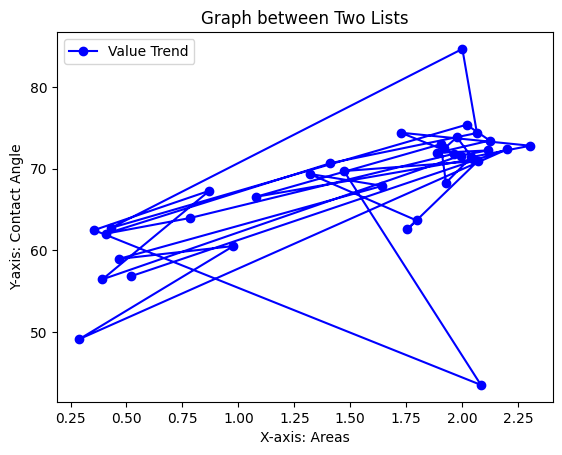

In [137]:
print(areas)
areas_list = np.array(areas)
angle_list = (np.sum(angless, axis=1)/2)
print(angle_list)

plt.plot(areas_list*1000, angle_list, marker='o', linestyle='-', color='b', label='Value Trend')

# Adding labels and title
plt.xlabel('X-axis: Areas')
plt.ylabel('Y-axis: Contact Angle')
plt.title('Graph between Two Lists')

# Adding legend
plt.legend()

# Display the graph
plt.show()



In [142]:
areas = areas_list

frame_num = []
filtered_frames_file = "/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/BG_Subtraction/filtered_frames.txt"
lines = read_filtered_frames(filtered_frames_file)
for line in lines:
    frame_num.append(int(line[0]))
print(frame_num)


[16, 24, 39, 179, 197, 264, 296, 306, 308, 346, 392, 438, 438, 456, 470, 472, 476, 527, 599, 617, 646, 669, 696, 712, 760, 817, 841, 874, 910, 930, 934, 935, 944, 955, 960, 989]


1080 1920


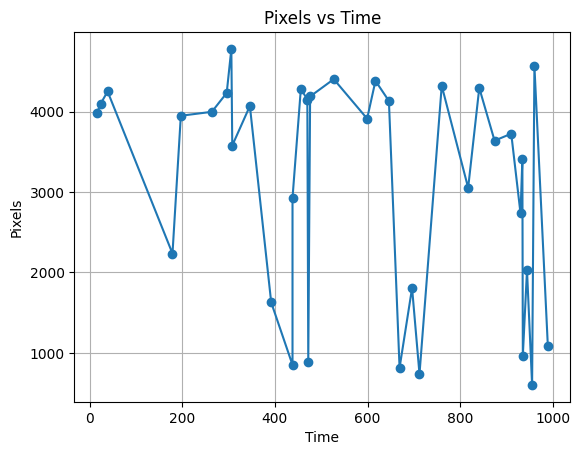

In [143]:
import matplotlib.pyplot as plt

areas_np = np.array(areas)
# Plotting the data
print(h,w)
plt.plot(frame_num, areas_np*h*w, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Pixels')
plt.title('Pixels vs Time')

# Displaying the plot
plt.grid(True)  # Enable grid
plt.show()


1080 1920


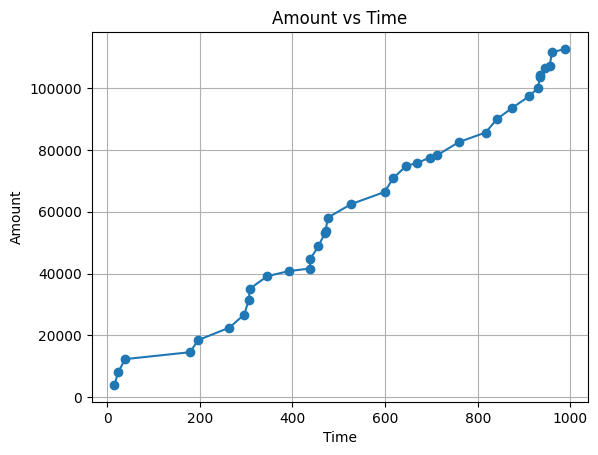

In [144]:
import matplotlib.pyplot as plt

areas_np = np.array(areas)
areas_np = areas_np*h*w

cumulative_areas = [sum(areas_np[:i+1]) for i in range(len(areas_np))]
# Plotting the data
cumulative_areas = np.array(cumulative_areas)
print(h, w)
plt.plot(frame_num, cumulative_areas, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Amount vs Time')

# Displaying the plot
plt.grid(True)  # Enable grid
plt.show()

In [17]:
image = cv2.imread('Filtered_Frames/Frame_16.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

max_y = 0

if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        if (y2==462 or y2==589) and (theta<1.6 and theta>1.57):
            cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Display the image with detected lines
cv2.imwrite('image_with_detected_lines.jpg', image)

True

In [145]:
rod_upper = 462
rod_lower = 589
rod_diameter = rod_lower-rod_upper
rod_dia_mm = 6.35 #Needs to be changed
per_pix_len = rod_dia_mm/rod_diameter

In [48]:
def get_mass(area_in_px2, density):
    area = area_in_px2*(per_pix_len**2)
    vol = (4/3)*(np.pi**(-1/2))*(area**1.5)
    return vol*density

In [153]:
import math
def get_radius(area_in_px2, per_pix_len):
    px_rad = math.sqrt(area_in_px2)
    rad_mm = px_rad*per_pix_len
    return rad_mm 

def get_volume(rad):
    return (4*np.pi*(np.array(rad)**3))/3


rad = []
for area in areas_np:
    rad.append(get_radius(area, per_pix_len))
print(rad)
vol = get_volume(rad)
print(vol)


[3.1555506650979317, 3.2007811546558442, 3.2596012026013237, 2.3637893307145625, 3.1416556144810013, 3.161091583614748, 3.2526911934581184, 3.456515586540873, 2.990819285747636, 3.1894356867634124, 2.0168044030098704, 1.457737973711325, 2.7050877989447955, 3.272613634390714, 3.220636583037583, 1.4924811556599298, 3.2357379374726873, 3.3177552652358187, 3.1272991542223774, 3.309833832687073, 3.214031735997639, 1.425657742938325, 2.124852936087578, 1.3564659966250534, 3.2867156859089586, 2.7622454633866265, 3.276430985081175, 3.015791770000044, 3.0516389039334255, 2.6143832924802743, 2.9189039038652846, 1.5540270267920053, 2.25166604983954, 1.2257650672131262, 3.378239186321774, 1.6439282222773595]
[131.61763473 137.35882067 145.07147188  55.32417081 129.88659693
 132.312186   144.15081789 172.9832961  112.06219546 135.90334841
  34.36212012  12.97558691  82.9149238  146.81580663 139.93094741
  13.92564047 141.90857264 152.97541868 128.11408863 151.88230594
 139.07180507  12.13764527  40

In [158]:
def mass_time_graph(cum_mass, frame_num, frame_rate):
    frame_num = np.array(frame_num)
    time = frame_num/frame_rate
    plt.plot(time, cum_mass, marker='o')
    plt.xlabel('Time (in sec.)')
    plt.ylabel('Vol (in mm**3)')
    plt.title('Vol of Water falling vs Time')
    # Displaying the plot
    plt.grid(True)  # Enable grid
    plt.show()

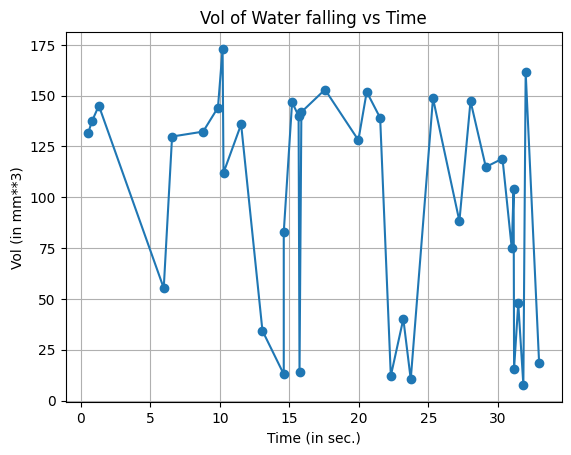

In [159]:
mass_time_graph(vol, frame_num, 30)

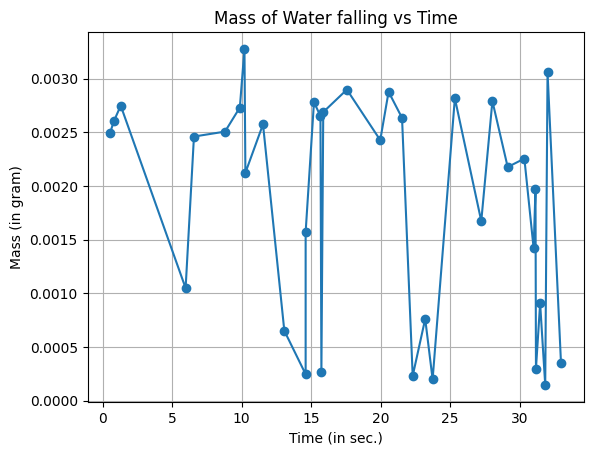

In [86]:
cum_mass = get_mass(areas_np,1) 
time = np.array(frame_num)/30
mass_time_graph(cum_mass, frame_num, 30)

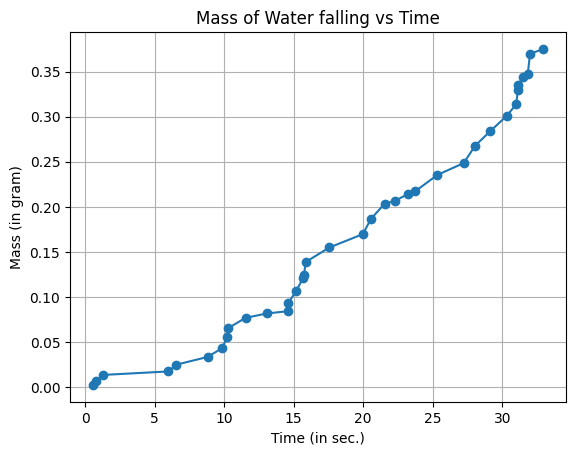

In [87]:
# cumulative_areas = np.array(cumulative_areas)
cum_mass = get_mass(cumulative_areas,1) 
mass_time_graph(cum_mass, frame_num, 30)

In [92]:
def calculate_slope(x1, y1, x2, y2):
    delta_y = y2 - y1
    delta_x = x2 - x1
    if delta_x == 0:
        return None  # Avoid division by zero
    slope = delta_y / delta_x
    return slope

# Sample x and y values for 20 data points
x_values = time
y_values = cum_mass

# Calculate the slope for each pair of points
slopes = []
for i in range(len(x_values) - 15):
    slope = calculate_slope(x_values[i], y_values[i], x_values[i + 15], y_values[i + 15])
    if slope is not None:  # Check if slope is a number
        slopes.append(slope)

# Average the slopes
average_slope = sum(slopes) / len(slopes)

print("No. of Slopes:", len(slopes))
print("Average Slope:", average_slope)

No. of Slopes: 21
Average Slope: 0.012330643744314812


In [82]:
import csv

data = list(zip(cum_mass,frame_num))

csv_file = "cumulative_area_data.csv"

# Write the data to a CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Mass (in gms)'])  # Write header
    writer.writerows(data)